In [1]:
import numpy as np 
import pandas as pd 
import os 
import random 
from PIL import Image,ImageDraw
from collections import Counter 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
import torch 
import torchvision 
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [2]:
import pandas as pd
import json

# Load the JSON file
json_file_path = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/coco_instances.json'
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Extract annotations list
annotations = data['annotations']
images = data['images']
categories = data['categories']

# Create lists to store annotation data (bbox) and image data (file details)
image_ids = []
category_ids = []
bbox_x = []
bbox_y = []
bbox_width = []
bbox_height = []
areas = []

# Iterate over each annotation and extract relevant data
for annotation in annotations:
    image_ids.append(annotation['image_id'])
    category_ids.append(annotation['category_id'])
    
    # Extract bbox data (x, y, width, height)
    bbox = annotation['bbox']
    bbox_x.append(bbox[0])
    bbox_y.append(bbox[1])
    bbox_width.append(bbox[2])
    bbox_height.append(bbox[3])
    
    # Extract area data
    areas.append(annotation['area'])

# Create DataFrame for annotations
df_annotations = pd.DataFrame({
    'image_id': image_ids,
    'category_id': category_ids,
    'bbox_x': bbox_x,
    'bbox_y': bbox_y,
    'bbox_width': bbox_width,
    'bbox_height': bbox_height,
    'area': areas
})

# Create lists to store image data
licenses = []
file_names = []
widths = []
heights = []
ids = []

# Iterate over each image data and extract relevant fields
for image in images:
    licenses.append(image['license'])
    file_names.append(image['file_name'])
    widths.append(image['width'])
    heights.append(image['height'])
    ids.append(image['id'])

# Create DataFrame for image metadata
df_images = pd.DataFrame({
    'image_id': ids,
    'license': licenses,
    'file_name': file_names,
    'width': widths,
    'height': heights
})

# Create lists to store category data
category_ids = []
category_names = []
supercategories = []

# Iterate over each category data and extract relevant fields
for category in categories:
    category_ids.append(category['id'])
    category_names.append(category['name'])
    supercategories.append(category['supercategory'])

# Create DataFrame for category metadata
df_categories = pd.DataFrame({
    'category_id': category_ids,
    'category_name': category_names,
    'supercategory': supercategories
})

# Merge the annotation and image DataFrames on 'image_id'
df_combined = pd.merge(df_annotations, df_images, on='image_id')

# Merge the combined DataFrame with the categories DataFrame on 'category_id'
df_final = pd.merge(df_combined, df_categories, on='category_id')

# Example of subtracting bbox values: calculate the difference between width and height
df_final['bbox_difference'] = df_final['bbox_width'] - df_final['bbox_height']

# Display the final combined DataFrame
print(df_final.head())

# Optionally save the combined DataFrame to CSV
df_final.to_csv('combined_bbox_image_category_data.csv', index=False)


   image_id  category_id  bbox_x  bbox_y  bbox_width  bbox_height      area  \
0         0            3   114.5   128.5       116.0        147.0  11308.75   
1         1            3    11.5   195.5       114.0         97.0   4448.00   
2         1            3   101.5    65.5       173.0        207.0  18818.50   
3         1            3    52.5   119.5        77.0         74.0   3749.25   
4         2            3    94.5    18.5       174.0        173.0  12727.25   

   license     file_name  width  height category_name supercategory  \
0        0  00000000.jpg    300     300       plastic          Bags   
1        0  00000001.jpg    300     300       plastic          Bags   
2        0  00000001.jpg    300     300       plastic          Bags   
3        0  00000001.jpg    300     300       plastic          Bags   
4        0  00000002.jpg    300     300       plastic          Bags   

   bbox_difference  
0            -31.0  
1             17.0  
2            -34.0  
3             

In [3]:
df_final.tail()

image_id  category_id  bbox_x  bbox_y  bbox_width  bbox_height  \
29927     14998            1    75.5    79.5       116.0        181.0   
29928     14998            2    92.5    55.5       132.0        125.0   
29929     14999            2    44.0   195.5       105.5         81.0   
29930     14999            1    60.5    59.5        77.0        147.0   
29931     14999            2   101.0   101.5       107.5        175.0   

          area  license     file_name  width  height category_name  \
29927  15713.0        0  00014998.jpg    300     300       garbage   
29928   5049.0        0  00014998.jpg    300     300         paper   
29929   6341.5        0  00014999.jpg    300     300         paper   
29930   7363.5        0  00014999.jpg    300     300       garbage   
29931   8874.5        0  00014999.jpg    300     300         paper   

      supercategory  bbox_difference  
29927          Bags            -65.0  
29928          Bags              7.0  
29929          Bags             24.5  
29930          Bags            -70.0  
29931          Bags            -67.5

In [4]:
# Rename the columns 'bbox_x' to 'x1' and 'bbox_y' to 'y1'
df_final = df_final.rename(columns={'bbox_x': 'x1', 'bbox_y': 'y1'})

# Check the updated DataFrame
print(df_final.head())
df=df_final
df=df[df['image_id'] <= 5000]

   image_id  category_id     x1     y1  bbox_width  bbox_height      area  \
0         0            3  114.5  128.5       116.0        147.0  11308.75   
1         1            3   11.5  195.5       114.0         97.0   4448.00   
2         1            3  101.5   65.5       173.0        207.0  18818.50   
3         1            3   52.5  119.5        77.0         74.0   3749.25   
4         2            3   94.5   18.5       174.0        173.0  12727.25   

   license     file_name  width  height category_name supercategory  \
0        0  00000000.jpg    300     300       plastic          Bags   
1        0  00000001.jpg    300     300       plastic          Bags   
2        0  00000001.jpg    300     300       plastic          Bags   
3        0  00000001.jpg    300     300       plastic          Bags   
4        0  00000002.jpg    300     300       plastic          Bags   

   bbox_difference  
0            -31.0  
1             17.0  
2            -34.0  
3              3.0  
4    

In [5]:
df.tail()

image_id  category_id     x1     y1  bbox_width  bbox_height      area  \
9986      4999            2  102.5   56.5       157.0        135.0  12400.25   
9987      4999            1   43.5  144.5       152.0        149.0  12047.75   
9988      5000            2  152.0   60.5       112.5         65.0   5403.00   
9989      5000            2   31.5   43.5       187.0        197.0  18254.50   
9990      5000            2  133.5  188.5       118.0         91.0   8229.25   

      license     file_name  width  height category_name supercategory  \
9986        0  00004999.jpg    300     300         paper          Bags   
9987        0  00004999.jpg    300     300       garbage          Bags   
9988        0  00005000.jpg    300     300         paper          Bags   
9989        0  00005000.jpg    300     300         paper          Bags   
9990        0  00005000.jpg    300     300         paper          Bags   

      bbox_difference  
9986             22.0  
9987              3.0  
9988             47.5  
9989            -10.0  
9990             27.0

In [6]:
df.columns

Index(['image_id', 'category_id', 'x1', 'y1', 'bbox_width', 'bbox_height',
       'area', 'license', 'file_name', 'width', 'height', 'category_name',
       'supercategory', 'bbox_difference'],
      dtype='object')

In [7]:
df['x2']=df['x1']+df['bbox_width']
df['y2']=df['y1']+df['bbox_height']

/tmp/ipykernel_236/1551633381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x2']=df['x1']+df['bbox_width']
/tmp/ipykernel_236/1551633381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y2']=df['y1']+df['bbox_height']


In [8]:
unique_imgs=df.image_id.unique()
unique_imgs

array([   0,    1,    2, ..., 4998, 4999, 5000])

In [9]:
import os
import torch
from PIL import Image
import torchvision.transforms as T

class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices, base_path):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
        self.base_path = base_path

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Get the image file name (ID) based on the index
        image_id = self.unique_imgs[self.indices[idx]]
        
        # Check if the image_id is within the allowed range
        if image_id > 5000:
            print(f"Skipping image with ID: {image_id} because it is greater than 5000")
            return None, None
        
#         print(f"Accessing image with ID: {image_id}")
        
        # Filter the DataFrame to get data for this image ID
        img_data = self.df[self.df['image_id'] == image_id]
        
        if img_data.empty:
            print(f"No data found for image ID: {image_id}")
            return None, None

        # Extract bounding boxes and other information
        boxes = img_data[['x1', 'y1', 'x2', 'y2']].values.astype('float')
        category_name = img_data['category_name'].values[0]
        file_name = img_data['file_name'].values[0]
        
        # Capitalize the first letter of category_name
        category_name = category_name.capitalize()

        # Construct the full file path for the image
        file_path = os.path.join(self.base_path, 'Bag Classes', 'Bag Classes', category_name + ' Bag Images', file_name)
        
        # Print the file path to verify it's correct
#         print(f"Constructed file path: {file_path}")

        if not os.path.exists(file_path):
#             print(f"File does not exist: {file_path}")
            return None, None

        # Load the image (but not visualize or return it)
        img = Image.open(file_path).convert('RGB')

        # Create labels for bounding boxes (assuming binary classification for now)
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)

        # Prepare the target dictionary with boxes and labels
        target = {}
        target['boxes'] = torch.tensor(boxes, dtype=torch.float32)
        target['labels'] = labels

        # Convert the image to a tensor
        img = T.ToTensor()(img)

        return img, target


In [10]:
def custom_collate(batch):
    imgs = []
    targets = []
    for item in batch:
        img, target = item
        if img is not None and target is not None:
            imgs.append(img)
            targets.append(target)
    return imgs, targets



In [11]:
train_inds,val_inds=train_test_split(range(unique_imgs.shape[0]),test_size=.1)

In [12]:

# Step 2: Define the indices (you can use all images or a subset)
indices = list(range(len(unique_imgs)))  # Use all images

# Step 3: Define the base path to the image folders
base_path = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/'


In [13]:
train_dl=torch.utils.data.DataLoader(CustDat(df,unique_imgs,train_inds,base_path),
                                    batch_size=16,shuffle=True,
                                    collate_fn=custom_collate,
                                    pin_memory=True if torch.cuda.is_available() else False)
val_dl=torch.utils.data.DataLoader(CustDat(df,unique_imgs,train_inds,base_path),
                                    batch_size=8,shuffle=True,
                                    collate_fn=custom_collate,
                                    pin_memory=True if torch.cuda.is_available() else False)


In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
model = model.to(device)

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs=5

In [18]:
for epoch in range(num_epochs):
    epoch_loss = 0
    
    # Iterate over batches of data from the DataLoader
    for imgs, targets in train_dl:
        # Move images and targets to device
        imgs = [img.to(device) for img in imgs]  # Move images to device
        for target in targets:
            target['boxes'] = target['boxes'].to(device)  # Move bounding boxes to device
            target['labels'] = target['labels'].to(device)  # Move labels to device
                


        # Forward pass
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        
        # Backpropagation
        epoch_loss += loss.cpu().detach().numpy()  # Convert the loss to a CPU-readable value
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch loss after each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}')

# Print final loss after all epochs
print(f'Final Epoch Loss: {epoch_loss}')


Epoch 1/5, Loss: 126.68664503097534
Epoch 2/5, Loss: 127.24301815032959
Epoch 3/5, Loss: 133.65243887901306
Epoch 4/5, Loss: 135.42599415779114
Epoch 5/5, Loss: 136.24024134874344
Final Epoch Loss: 136.24024134874344


In [33]:
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2

    ix1 = max(x1, x1_gt)
    iy1 = max(y1, y1_gt)
    ix2 = min(x2, x2_gt)
    iy2 = min(y2, y2_gt)

    iw = max(0, ix2 - ix1 + 1)
    ih = max(0, iy2 - iy1 + 1)
    inter_area = iw * ih

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_gt - x1_gt + 1) * (y2_gt - y1_gt + 1)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0


In [34]:
def compute_precision_recall(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_gt = [False] * len(gt_boxes)

    for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
        best_iou = 0
        best_gt_idx = -1

        for i, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
            if pred_label == gt_label:
                iou = compute_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = i

        if best_iou >= iou_threshold and best_gt_idx >= 0 and not matched_gt[best_gt_idx]:
            true_positives += 1
            matched_gt[best_gt_idx] = True
        else:
            false_positives += 1

    false_negatives = len(gt_boxes) - sum(matched_gt)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall


In [35]:
def compute_precision_recall(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_gt = [False] * len(gt_boxes)

    for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
        best_iou = 0
        best_gt_idx = -1

        for i, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
            if pred_label == gt_label:
                iou = compute_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = i

        if best_iou >= iou_threshold and best_gt_idx >= 0 and not matched_gt[best_gt_idx]:
            true_positives += 1
            matched_gt[best_gt_idx] = True
        else:
            false_positives += 1

    false_negatives = len(gt_boxes) - sum(matched_gt)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall


In [22]:
model.eval()  # Switch to evaluation mode


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [68]:
from PIL import Image
import torchvision.transforms as T

# Load the image
image_path = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/test_image.jpg'
image = Image.open(image_path).convert('RGB')

# Define the transformations (same as used during training)
transform = T.Compose([
    T.ToTensor(),
])

# Apply the transformations
img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device


In [69]:
with torch.no_grad():  # No need to compute gradients during inference
    predictions = model(img_tensor)


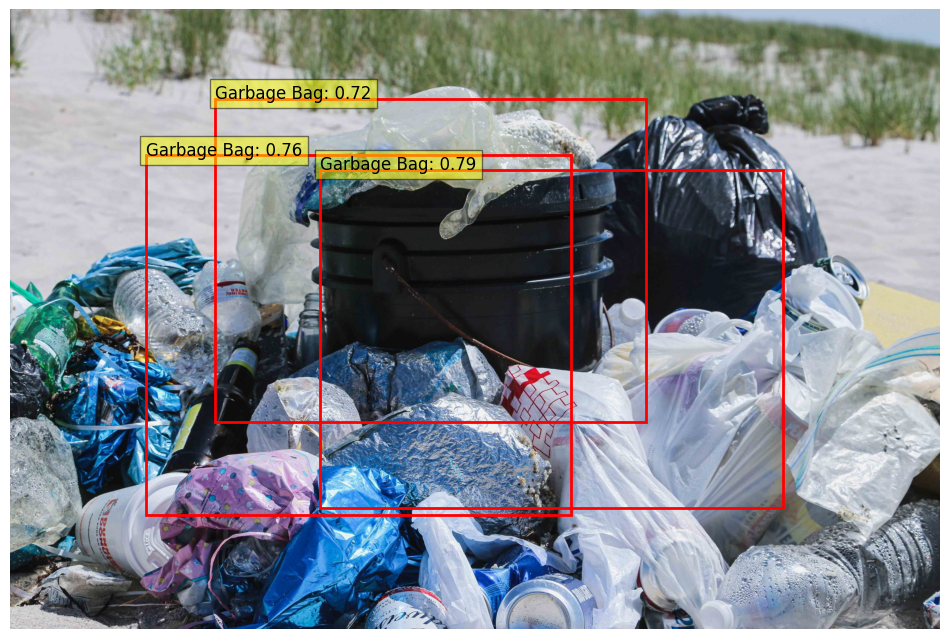

In [70]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Extract predictions
pred_boxes = predictions[0]['boxes']
pred_labels = predictions[0]['labels']
pred_scores = predictions[0]['scores']

# Filter out predictions with a low score
threshold = 0.7
keep = pred_scores >= threshold
pred_boxes = pred_boxes[keep].cpu().numpy()
pred_labels = pred_labels[keep].cpu().numpy()
pred_scores = pred_scores[keep].cpu().numpy()

# Define the class names (update according to your dataset)
class_names = {0: 'Plastic Bag', 1: 'Garbage Bag', 2: 'paper Bag'}

# Visualize the results
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    class_name = class_names.get(int(label), 'Unknown')  # Get the class name
    text = f'{class_name}: {score:.2f}'
    plt.text(x1, y1, text, bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black')

plt.axis('off')
plt.show()


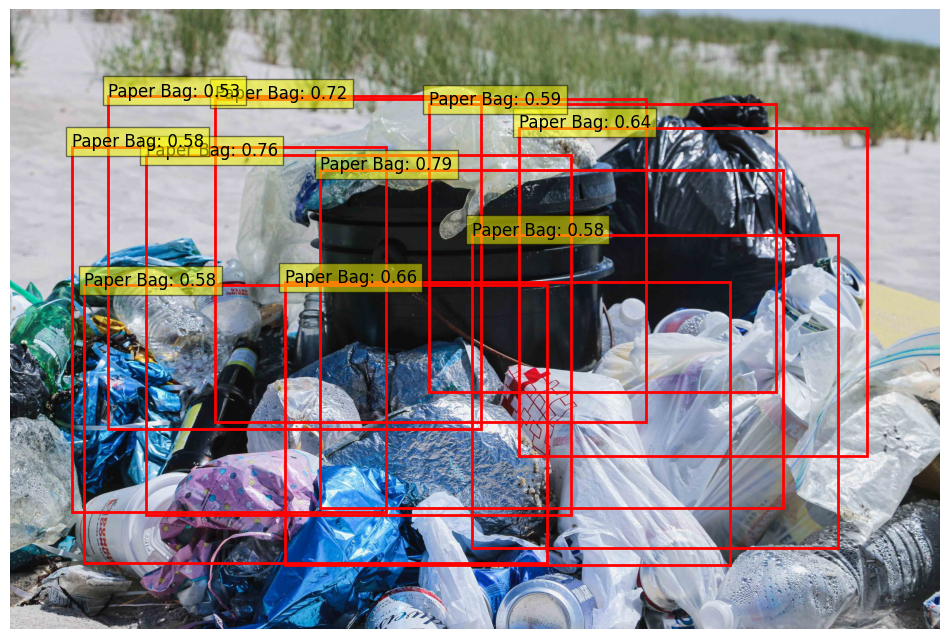

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming you have the necessary data structures (pred_boxes, pred_labels, pred_scores, image)

# Filter out predictions with a low score (optional)
threshold = 0.5
keep = pred_scores >= threshold
pred_boxes = pred_boxes[keep]  # No need for .cpu()
pred_labels = pred_labels[keep]
pred_scores = pred_scores[keep]

# Define class names (update according to your dataset)
class_names = {0: 'Garbage Bag', 1: 'Paper Bag', 2: 'Plastic Bag'}

# Visualize the results
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
    x1, y1, x2, y2 = box

    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Ensure label is an integer and within the class_names range
    if int(label) in class_names:
        class_name = class_names[int(label)]
    else:
        class_name = 'Unknown'  # Handle out-of-range labels

    # Display class name and score
    text = f'{class_name}: {score:.2f}'
    plt.text(x1, y1, text, bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black')

plt.axis('off')
plt.show()

### for debugging

In [19]:
# Check the content for specific image IDs
for image_id in unique_imgs[:10]:
    # Convert the image_id to the filename format (zero-padded with .jpg extension)
    image_id_filename = f"{str(image_id).zfill(8)}.jpg"
    
    # Print the rows that match the current image_id_filename
    print(df[df['file_name'] == image_id_filename])


   image_id  category_id     x1     y1  bbox_width  bbox_height      area  \
0         0            3  114.5  128.5       116.0        147.0  11308.75   

   license     file_name  width  height category_name supercategory  \
0        0  00000000.jpg    300     300       plastic          Bags   

   bbox_difference     x2     y2  
0            -31.0  230.5  275.5  
   image_id  category_id     x1     y1  bbox_width  bbox_height      area  \
1         1            3   11.5  195.5       114.0         97.0   4448.00   
2         1            3  101.5   65.5       173.0        207.0  18818.50   
3         1            3   52.5  119.5        77.0         74.0   3749.25   

   license     file_name  width  height category_name supercategory  \
1        0  00000001.jpg    300     300       plastic          Bags   
2        0  00000001.jpg    300     300       plastic          Bags   
3        0  00000001.jpg    300     300       plastic          Bags   

   bbox_difference     x2     y2  
1  

Batch targets: [{'boxes': tensor([[ 70.5000,   6.5000, 203.5000, 186.5000],
        [ 30.5000,  44.5000, 109.5000, 202.5000],
        [ 20.5000,  75.5000, 160.5000, 249.5000]]), 'labels': tensor([1, 1, 1])}, {'boxes': tensor([[ 66.5000, 104.5000, 158.5000, 277.5000]]), 'labels': tensor([1])}, {'boxes': tensor([[ 67.5000,  72.5000, 225.5000, 267.5000]]), 'labels': tensor([1])}, {'boxes': tensor([[ 54.5000,  50.5000, 208.5000, 163.5000]]), 'labels': tensor([1])}, {'boxes': tensor([[ 67.5000,  67.5000, 223.5000, 262.5000]]), 'labels': tensor([1])}, {'boxes': tensor([[ 21.5000,  90.5000, 184.5000, 241.5000]]), 'labels': tensor([1])}, {'boxes': tensor([[ 62.5000, 168.5000, 235.5000, 284.5000],
        [ 84.5000, 130.5000, 269.5000, 244.5000],
        [ 84.5000,  78.5000, 242.0000, 206.5000]]), 'labels': tensor([1, 1, 1])}, {'boxes': tensor([[ 36.5000, 104.5000, 151.5000, 246.5000]]), 'labels': tensor([1])}, {'boxes': tensor([[ 19.5000, 168.5000, 141.5000, 263.5000]]), 'labels': tensor([1])}

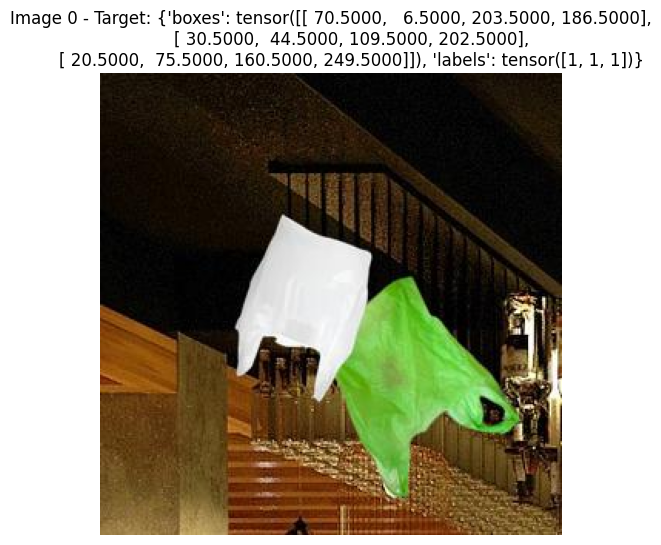

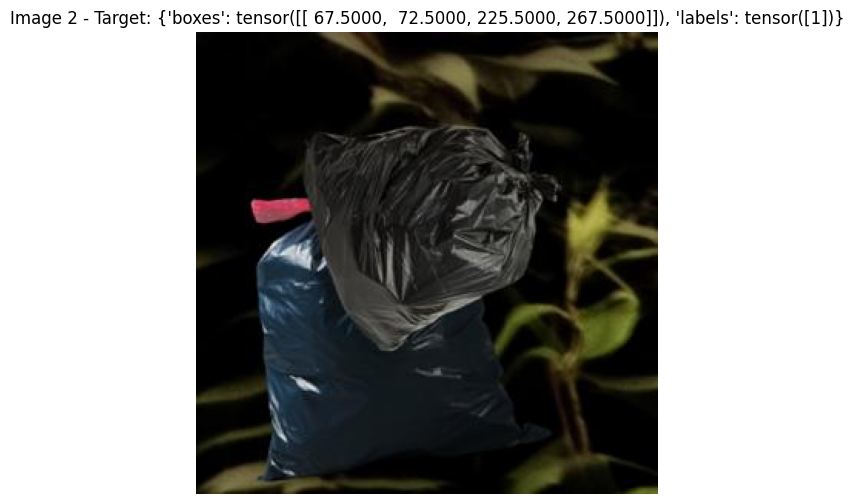

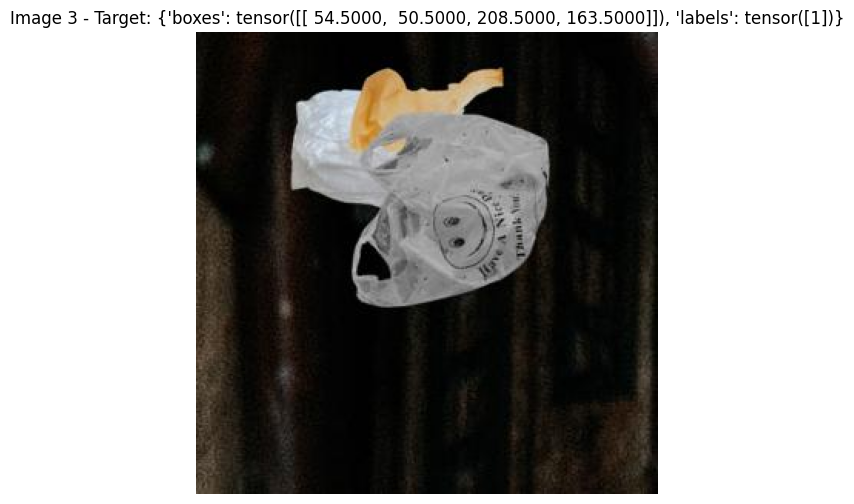

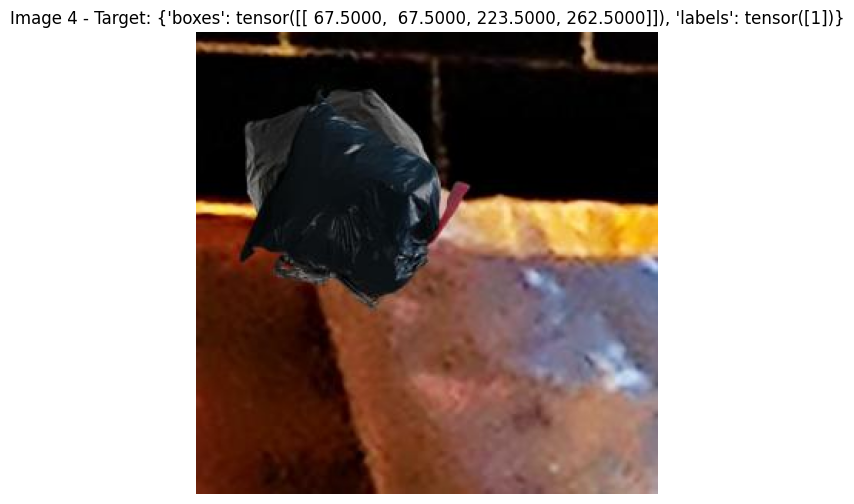

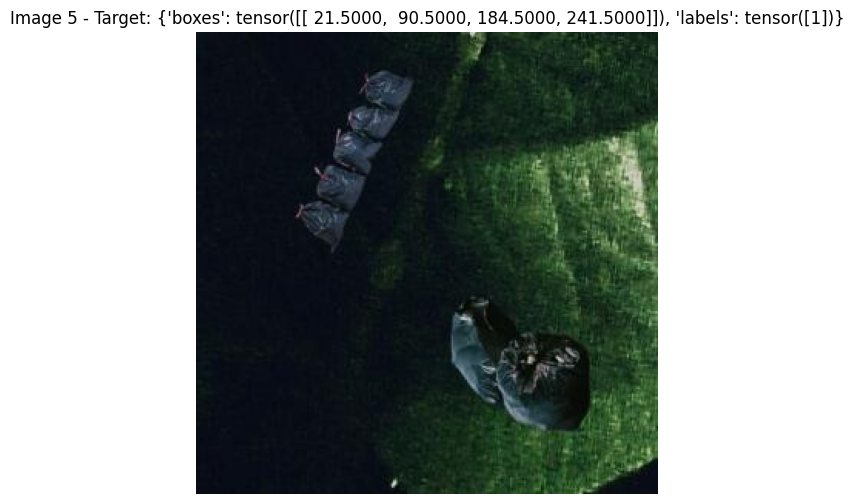

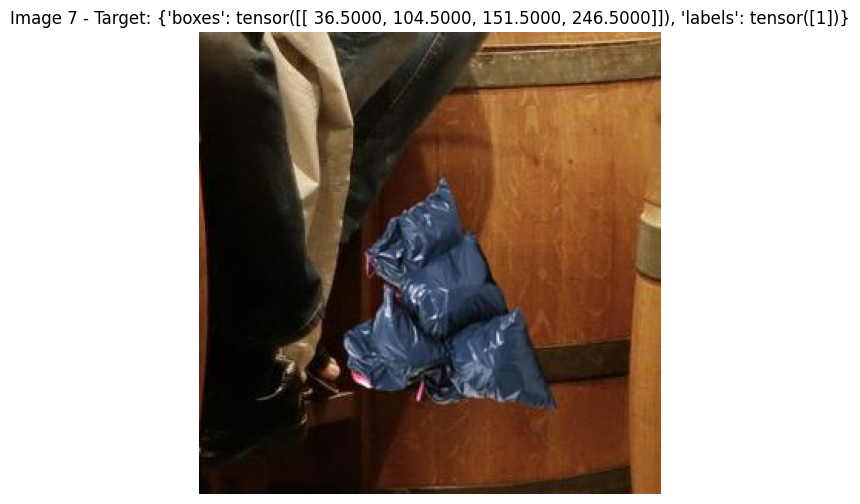

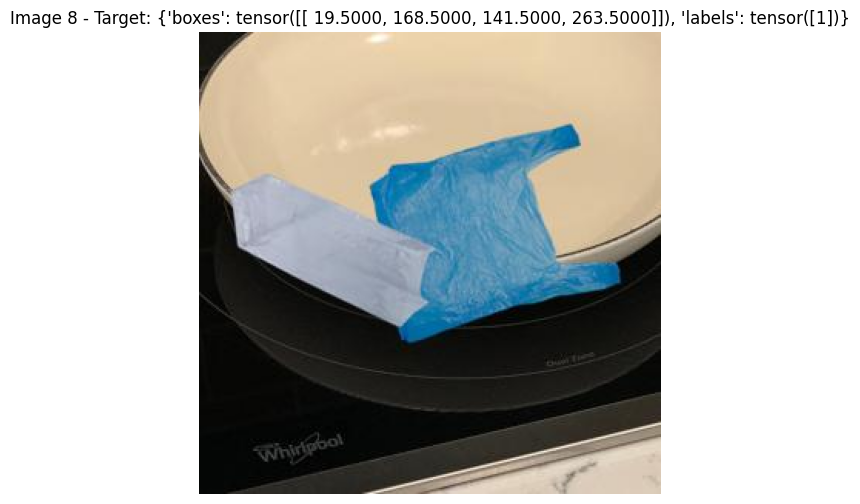

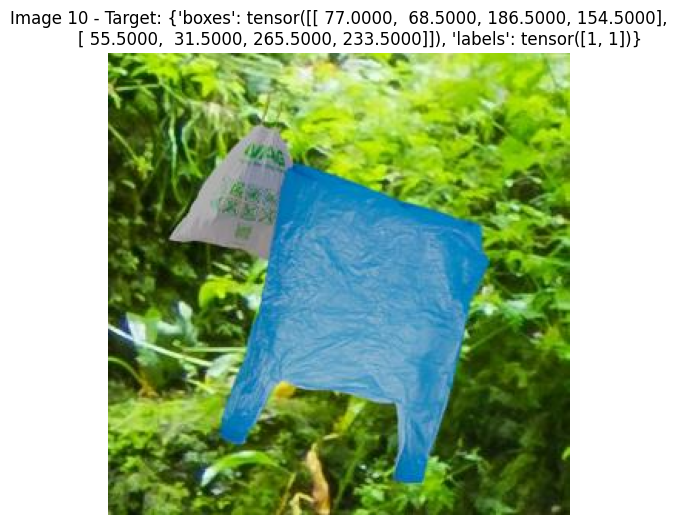

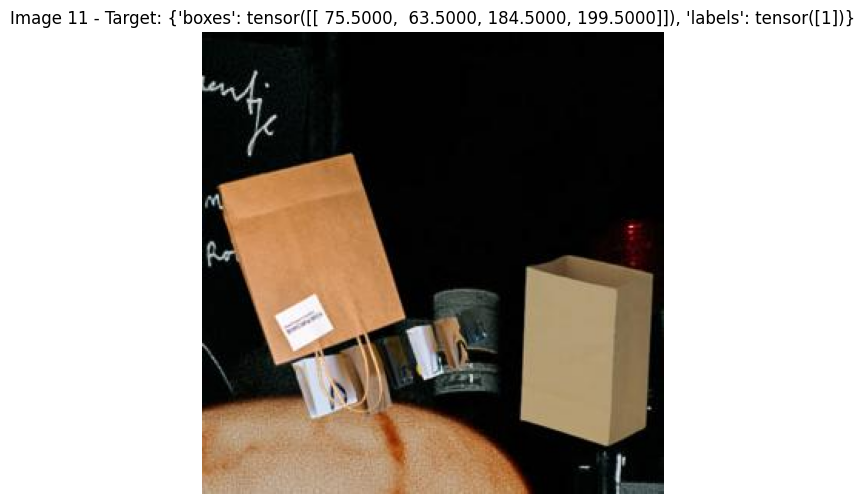

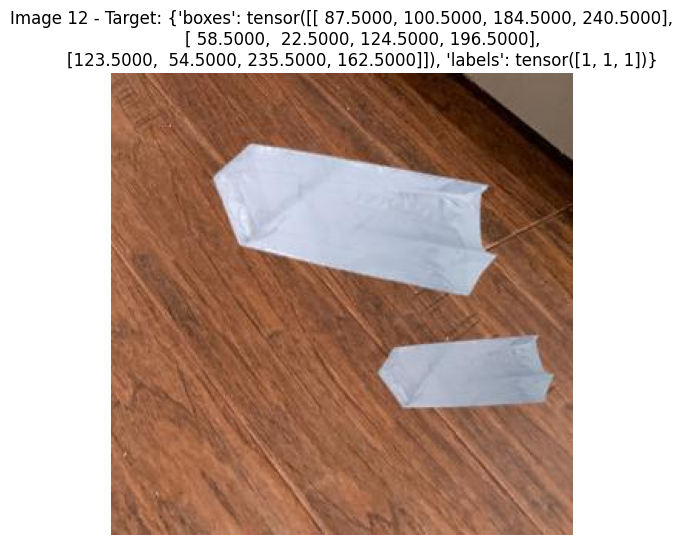

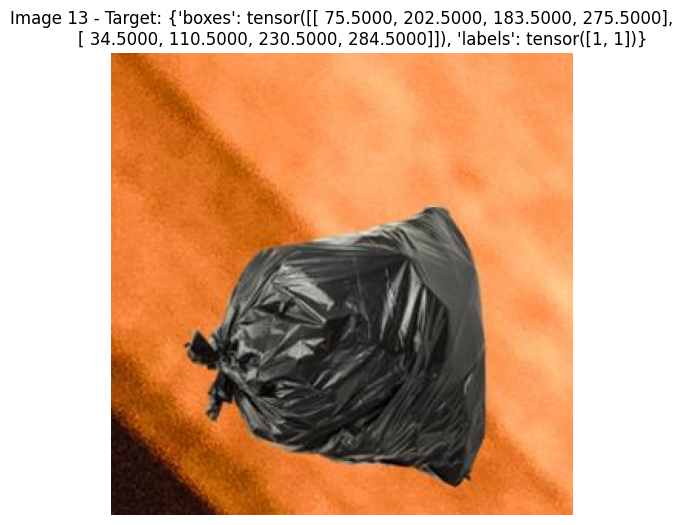

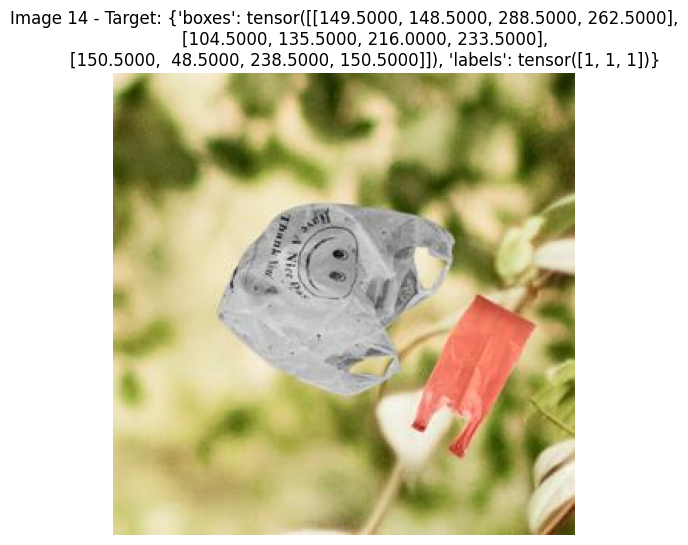

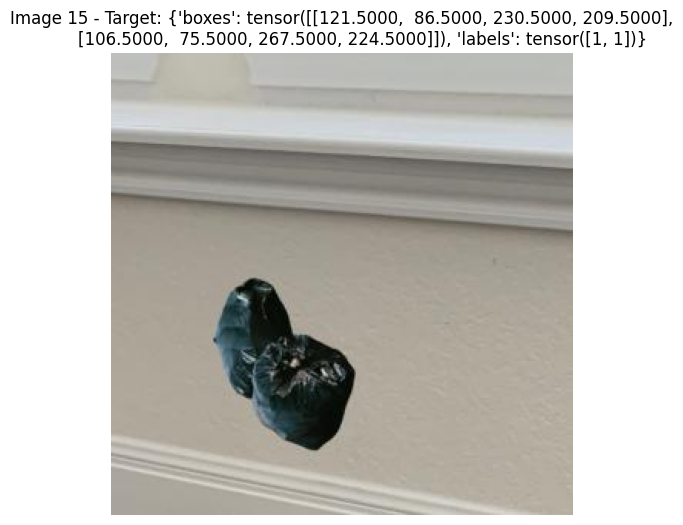

In [20]:
for imgs, targets in train_dl:
#     print("Batch imgs shape:", imgs.shape)  # Check the shape of the image tensor batch
    print("Batch targets:", targets)
    # Optionally visualize a batch of images
    for i in range(len(imgs)):
        plt.figure(figsize=(6, 6))
        plt.imshow(T.ToPILImage()(imgs[i]))
        plt.title(f"Image {i} - Target: {targets[i]}")
        plt.axis('off')
        plt.show()
    break  # Remove break to iterate through all batches

In [71]:
# plt.imshow(transforms.ToPILImage()(imgs[i]))

In [72]:
# Define and instantiate the dataset
dataset = CustDat(df, unique_imgs, indices, base_path)

# Fetch a sample to trigger the print statements
img, target = dataset[0]
print(img)
print(target)

tensor([[[0.0706, 0.0784, 0.0902,  ..., 0.1451, 0.1451, 0.1412],
         [0.0706, 0.0784, 0.0902,  ..., 0.1490, 0.1451, 0.1451],
         [0.0706, 0.0784, 0.0902,  ..., 0.1490, 0.1451, 0.1451],
         ...,
         [0.0745, 0.0745, 0.0745,  ..., 0.1451, 0.1451, 0.1451],
         [0.0745, 0.0745, 0.0745,  ..., 0.1451, 0.1451, 0.1451],
         [0.0745, 0.0745, 0.0745,  ..., 0.1333, 0.1333, 0.1333]],

        [[0.0275, 0.0353, 0.0471,  ..., 0.1020, 0.1020, 0.0980],
         [0.0275, 0.0353, 0.0471,  ..., 0.1059, 0.1020, 0.1020],
         [0.0275, 0.0353, 0.0471,  ..., 0.1059, 0.1020, 0.1020],
         ...,
         [0.0314, 0.0314, 0.0314,  ..., 0.1059, 0.1059, 0.1059],
         [0.0314, 0.0314, 0.0314,  ..., 0.1059, 0.1059, 0.1059],
         [0.0314, 0.0314, 0.0314,  ..., 0.0941, 0.0941, 0.0941]],

        [[0.0431, 0.0510, 0.0627,  ..., 0.0941, 0.0941, 0.0902],
         [0.0431, 0.0510, 0.0627,  ..., 0.0980, 0.0941, 0.0941],
         [0.0431, 0.0510, 0.0627,  ..., 0.0980, 0.0941, 0.

In [75]:
import torch

print(torch.cuda.is_available())


True


In [ ]:
# For numeric columns, use this:
image_id = 5716
filtered_df = df[df['image_id'] == image_id]

# Display the filtered DataFrame
print(filtered_df)
import matplotlib.pyplot as plt
from PIL import Image

# Define the image path
# image_path = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/Bag Classes/Bag Classes/Garbage Bag Images/00005716.jpg'
image_path = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/Bag Classes/Bag Classes/Garbage Bag Images/00005716.jpg'

# Open the image
image = Image.open(image_path)

# Visualize the image
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner image display
plt.show()


In [ ]:
import os

# Define the path to the image
image_path = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/Bag Classes/Bag Classes/Garbage Bag Images/00005716.jpg'

# Check if the file exists
if os.path.isfile(image_path):
    print(f"Image file {image_path} exists.")
else:
    print(f"Image file {image_path} does not exist.")


In [ ]:
import os

# Define the base path
base_path = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/Bag Classes/Bag Classes'

# List of folders you want to check
folders = ['Garbage Bag Images', 'Paper Bag Images', 'Plastic Bag Images']

# Dictionary to store the count of image files
image_counts = {}

# Loop through each folder
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    
    # Check if the folder exists
    if os.path.isdir(folder_path):
        # Count image files in the folder
        image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        image_count = len(image_files)
        image_counts[folder] = image_count
    else:
        image_counts[folder] = 0  # Folder does not exist

# Print the results
for folder, count in image_counts.items():
    print(f"Number of image files in '{folder}': {count}")
